# Methodology


 We want to extend the insights that Zeek and RITA are giving us about the probable sketchiness of particular connections. The goal in this notebook is to explain the data analaysis in a way that other, more fluid, tools can be built. 
 
 
**RITAs statistical analysis plus locally gathered heuristics**   
 RITA and Zeek are fantastic tools to explore traffic and narrow down bad actors but published blacklists are always laggy and incomplete, when they work and are supported. Also - the scoring doesn't filter for items like DNS or other known-good services, which adds to the SecOps response time to filter.  Here we can bring some low-cost tools to bear and some local understanding to narrow down what to invest time into, good or bad.


Some methods we're using:
- Combine Beacons and Conns files to identify unique talkers
- retrieve BGP Autonomous Systems info to identify originators (or listeners) in Wild West areas

also - are we getting connections from nets that practice good hygiene? 
- does an ip have a DNS entry?
- does an ip have a PTR record?

What local tools can add dimension?
- was the sender identified as malicious by other means? (fail2ban ICMP type 3 returns)


Unfortunately these don't work anymore:
- MalwareDomains.com
- MalwareDomainList.com
- malware-domains.com

Fresher Blacklist providers (as of 8/2021):
- https://urlhaus.abuse.ch/downloads/csv/
- https://github.com/curbengh/urlhaus-filter
- https://github.com/StevenBlack/hosts



**Home and Home Office Networks**  
You may want to analyze office or home net traffic and find out chatty corporate tools. You can add your own, but this will add a score to tag "friendly surveillance" from Apple, Google, et al. My lists are US-Centric - tailor to your locale. These may or may not be things you want in your custom RITA blacklist, but you may not know what they are yet. 





In [1]:
# imports
import pandas as pd
import numpy as np

# Viz imports
import matplotlib.pyplot as plt
import seaborn as sns

# Config matplotlib
%matplotlib inline
plt.rcParams["patch.force_edgecolor"] = True # in matplotlib, edge borders are turned off by default.
sns.set_style("darkgrid") # set a grey grid as a background

# turn off warnings
import warnings
warnings.filterwarnings('ignore')

import csv
import json
import datetime as datetime
import time

# ip/AS lookup tools
import socket
from ipwhois import IPWhois
from ipwhois.net import Net
from ipwhois.asn import IPASN

In [2]:
# define corporate target AS Descriptors
invasive_corps = ['AMAZON','APPLE','GOOGLE','MICROSOFT','CLOUDFLARENET','SALESFORCE','AKAMAI','OPENDNS']
sketchy_countries = ['CN','RU','VN','HK','TW','IN','BR','RO','HU','KR','IT','UG','TR','MY','BO','CO']


In [3]:
sketchy_providers = []
providers = open('beaconish_asns','r').readlines()
for p in providers:
    sketchy_providers.append(p.split()[0])

In [4]:
sketchy_providers[:5]

['AS-SONICTELECOM,', 'ASIANET', 'ASN-SPIN,', 'ASN-WINDTRE', 'BAIDU']

### load data

this takes the output of rita show-long-connections (dfconns) and rita show-beacons (dfbeacons).

The obscured IPs must be the same for each file - we merge the two on a matched ipsrc->ipdst key. The df will fail to create if there is nothing to merge on.

In [5]:
dfbeacons = pd.read_csv('records/scrubbed_ext_20210315062437_beacons.csv')
dfconns = pd.read_csv('records/scrubbed_ext_20210315062437_longconns.csv')
#dfdns = pd.read_csv('dns.csv')

In [6]:
dfbeacons.head(1)

,Score,Source IP,Destination IP,Connections,Avg Bytes,Intvl Range,Size Range,Top Intvl,Top Size,Top Intvl Count,Top Size Count,Intvl Skew,Size Skew,Intvl Dispersion,Size Dispersion
0,0.874,122.194.229.37,192.168.23.89,43244,60,308072,2583,11,60,7773,43188,0.0,0.0,1,0


In [7]:
dfconns.head(1)

,Source IP,Destination IP,Port:Protocol:Service,Duration
0,97.113.95.12,192.168.23.89,53718:tcp:- 53716:tcp:- 44496:tcp:- 44494:tcp:...,367302.0


### merge 

In [8]:
dfconns['ConnString'] = dfconns['Source IP'] + '->' + dfconns['Destination IP']

In [9]:
dfbeacons['ConnString'] = dfbeacons['Source IP'] + '->'+ dfbeacons['Destination IP']

In [10]:
df = pd.merge(dfbeacons, dfconns, on=['ConnString'], how='inner')

In [12]:
df.head(3)

,Score,Source IP_x,Destination IP_x,Connections,Avg Bytes,Intvl Range,Size Range,Top Intvl,Top Size,Top Intvl Count,Top Size Count,Intvl Skew,Size Skew,Intvl Dispersion,Size Dispersion,ConnString,Source IP_y,Destination IP_y,Port:Protocol:Service,Duration
0,0.835,65.254.18.118,192.168.23.89,1224,88,101090,7306,600,60,1052,1201,0.0,0.0,0,0,65.254.18.118->192.168.23.89,65.254.18.118,192.168.23.89,25:tcp:- 25:tcp:smtp,596.079
1,0.834,104.153.105.82,192.168.23.89,272,1762,356385,147842,1,0,81,189,0.0,0.0,0,0,104.153.105.82->192.168.23.89,104.153.105.82,192.168.23.89,80:tcp:- 443:tcp:- 53:udp:dns,149.911
2,0.832,192.168.23.89,212.70.149.71,3005,104,7209,45408,110,88,930,2965,0.0,0.0,1,0,192.168.23.89->212.70.149.71,192.168.23.89,212.70.149.71,3:icmp:-,7123.610


### clean up merge data

since the merge key is an amagalm of connection to connection strings, the Source IP and Destination IP collision columns _x and _y should be erroneous.

**delete _ys and rename _x**

In [13]:
del df['Source IP_y']

In [14]:
del df['Destination IP_y']

In [15]:
df.rename(columns={"Destination IP_x": "Destination IP",'Source IP_x':'Source IP'}, inplace=True)

In [16]:
df.columns

Index(['Score', 'Source IP', 'Destination IP', 'Connections', 'Avg Bytes',
       'Intvl Range', 'Size Range', 'Top Intvl', 'Top Size', 'Top Intvl Count',
       'Top Size Count', 'Intvl Skew', 'Size Skew', 'Intvl Dispersion',
       'Size Dispersion', 'ConnString', 'Port:Protocol:Service', 'Duration'],
      dtype='object')

### adding hostname lookups

Not only is this helpful to get an eyeball sense of where streams are going, it gives you a good idea of what doesn't have a name. 

In [17]:
def iplookup(ipaddress):
    #print(ipaddress)
    try: 
        fullhostname = socket.gethostbyaddr(ipaddress)
        hostname = fullhostname[0]
    except Exception as e:
        hostname = ipaddress
    return hostname

#### This takes awhile.

In [18]:
df['Source Name'] = df['Source IP'].apply(iplookup)

#### This takes even longer.

Garbage connections often don't have a DNS record. The timeout process makes this table take awhile to build

In [53]:
# this takes awhile thanks to DNS timeouts
#start = datetime.datetime.now()
df['Destination Name'] = df['Destination IP'].apply(iplookup)


In [55]:
df[:3]

,Score,Source IP,Destination IP,Connections,Avg Bytes,Intvl Range,Size Range,Top Intvl,Top Size,Top Intvl Count,...,Source Name,asn,asn_cidr,asn_country,asn_desc,sketchy,iscorp,sketchy_provider,src_ptr,Destination Name
0,0.835,65.254.18.118,192.168.23.89,1224,88,101090,7306,600,60,1052,...,smtp.jobdivabk.com,46887,65.254.0.0/19,US,"LIGHTOWER, US",False,False,False,True,192.168.23.89
1,0.834,104.153.105.82,192.168.23.89,272,1762,356385,147842,1,0,81,...,v-104-153-105-82.unman-vds.premium-chicago.nfo...,14586,104.153.105.0/24,US,"NUCLEARFALLOUT-CHI, US",False,False,False,True,192.168.23.89
2,0.832,192.168.23.89,212.70.149.71,3005,104,7209,45408,110,88,930,...,192.168.23.89,204428,212.70.149.0/24,BG,"SS-NET, BG",False,False,False,False,212.70.149.71


### Describing the IP sets

In [56]:
# unique localhosts
len(df['Source IP'].unique())

116

In [57]:
df['Source IP'].unique()

array(['65.254.18.118', '104.153.105.82', '192.168.23.89',
       '49.235.37.144', '42.192.234.75', '45.119.126.59', '120.70.98.132',
       '61.221.64.5', '202.95.14.159', '190.210.182.179',
       '106.124.131.214', '157.131.240.195', '49.232.39.21',
       '211.219.18.186', '123.206.90.149', '190.85.94.106',
       '49.233.77.12', '114.219.157.97', '210.178.94.227',
       '118.212.146.30', '106.75.61.147', '129.211.119.202',
       '35.220.253.166', '119.45.177.219', '125.5.180.84',
       '134.175.111.215', '134.209.41.198', '189.110.163.26',
       '116.228.233.91', '190.171.133.10', '144.91.70.164',
       '101.89.213.84', '118.98.96.184', '64.64.227.224',
       '222.168.18.227', '103.10.87.54', '203.195.207.85',
       '121.4.111.232', '101.36.127.150', '2.196.193.181',
       '123.127.244.100', '121.241.244.92', '182.254.149.130',
       '81.68.243.13', '106.124.142.64', '1.220.185.149', '123.30.149.34',
       '103.55.62.78', '118.24.121.227', '120.92.166.166',
       '121.4

In [58]:
# unique targets
len(df['Destination IP'].unique())

640

In [59]:
# unique connections
len(df['ConnString'].unique())

754

### Adding AS info

If you're reading this I'm guessing that you probably already know what all this is and get why we're grading  data in this way. If not, read on:

**Quick BGP/AS intro (stolen liberally from Cloudflare's great tutorial):**  
The *Border Gateway Protocol (BGP)* is the postal service of the Internet. To manage these endpoints each network broken into smaller networks known as *Autonomous systems (AS)*. Each of these networks is essentially a large pool of routers run by a single organization. 

If we continue to think of BGP as the postal service of the Internet, AS’s are like individual post office branches. A town may have hundreds of mailboxes, but the mail in those boxes must go through the local postal branch before being routed to another destination. The internal routers within an AS are like mailboxes, they forward their outbound transmissions to the AS, which then uses BGP routing to get these transmissions to their destinations.

To get on the Internet you need an IP Block, which needs a BGP AS. The companies that own the AS are responsible for the traffic that goes through them. If you have a lot of bad traffic coming from one server in an AS then there's reason to believe that blocks in other IP space controlled by that AS are also probably poorly managed. 

**Grading traffic from a particular AS block**  
This may be part of a decision to drop traffic coming from a single server or from the entire IP space as a Network Admin, but in this context we're simply going to grade traffic to that AS as more suspicious.

**Grading traffic coming from a Country**
Each BGP area is controlled within a Region, which then distributes to countries who have laws regarding internet traffic, hacking, etc. Some countries are more permissive than others with regard to hacking, fraud and spam. While it's incorrect and unfair to grade the citizens or services of a country based on the worst of their netizens, it's reasonable to grade countries with overly promiscuous (or non-existent) laws about hacking higher for further review. 

**Grading traffic coming from a Company**  
Much of the same rules apply here - if a company has a policy for their devices to send tracking data home through your networks you should be able to know about it. If they have lax policies concerning network access or services that could host C2 or bad traffic, you should be able to know about that, too. 

#### add ASN columns

takes a little time for the lookups

In [29]:
def getDstAsInfo(ipaddress, category='asn', **kwargs):
    """
    This is meant to return AS info for everything not an rfc1918 and mark rfc1918 elsewhere
    df['Destination IP'].apply(getAsInfoKwargs, category='asncidr',axis=1)
    """
    private = ['10.','172.','192.168.']
    if '192.168' in ipaddress:
        return 'rfc1918'
    net = Net(ipaddress)
    obj = IPASN(net)
    results = obj.lookup()
    if category is None:
        return "no category"
        #print(category)
    
    if category == 'reg':
        return results['asn_registry']
    elif category == 'asnnum':
        return results['asn']
    elif category == 'asncidr':
        return results['asn_cidr']
    elif category == 'asncc':
        return results['asn_country_code']
    elif category == 'asndate':
        return results['asn_date']
    elif category == 'asndesc':
        return results['asn_description']
    else:
        return False
    

In [26]:
def getAsInfo(item, category='asn', **kwargs):
    """
    We want to do a lookup on the non-rfc1918 address either send or receive in one fell swoop
    
    df[['Source IP','Destination IP']].apply(getAsInfoKwargs, category='asncidr',axis=1)
    
    asncidr, asn, asn_desc, asn_country
    """
    one, two = item['Source IP'], item['Destination IP']
    target_ip = one
    
    private = ['10.','172.','192.168.']
    
    # get as info for the non-rfc1918 address
    if '192.168' in one:
        target_ip = two
    
    net = Net(target_ip)
    obj = IPASN(net)
    results = obj.lookup()
    
    if category == 'reg':
        return results['asn_registry']
    elif category == 'asn':
        return results['asn']
    elif category == 'asn_cidr':
        return results['asn_cidr']
    elif category == 'asn_country':
        return results['asn_country_code']
    elif category == 'asn_date':
        return results['asn_date']
    elif category == 'asn_desc':
        return results['asn_description']
    if category == 'all':
        return results['asn_cidr'], results['asn'], results['asn_description'],results['asn_country_code']
    else:
        return False
    

**loop through and add AS fields**

In [62]:
asdata = ['asn','asn_cidr','asn_country','asn_desc']
for a in asdata:
    df[a] =  df[['Source IP','Destination IP']].apply(getAsInfo,category=a,axis=1)

**how many are unique?**

In [30]:
len(df['asn'].unique())

200

In [33]:
df['asn'].unique()[:10]

array(['46887', '14586', '204428', '45090', '132203', '14061', '4134',
       '28361', '64050', '9498'], dtype=object)

In [34]:
len(df['asn_country'].unique())

58

In [35]:
df['asn_country'].unique()

array(['US', 'BG', 'CN', 'BR', 'SG', 'IN', 'MY', 'HK', 'RU', 'ES', 'CO',
       'TH', 'AU', 'ID', 'FR', 'CA', 'GB', 'PA', 'VN', 'HR', 'KR', 'BO',
       'TW', 'AR', 'VE', 'PH', 'SC', 'IT', 'PE', 'SV', 'TR', 'JP', 'PT',
       'MX', 'ZA', 'NG', 'CL', 'GT', 'DE', 'TN', 'MN', 'BY', 'IR', 'PS',
       'SE', 'PK', 'NL', 'CH', 'LA', 'MM', 'PL', 'KE', 'BE', 'EC', '',
       'IS', 'GR', 'EG'], dtype=object)

In [36]:
countries = df['asn_country'].unique()

In [38]:
df[['asn','asn_desc','Source IP']].value_counts()

asn    asn_desc                                                                    Source IP    
45090  CNNIC-TENCENT-NET-AP Shenzhen Tencent Computer Systems Company Limited, CN  192.168.23.89    173
14061  DIGITALOCEAN-ASN, US                                                        192.168.23.89     91
4134   CHINANET-BACKBONE No.31,Jin-rong Street, CN                                 192.168.23.89     33
16276  OVH, FR                                                                     192.168.23.89     26
56046  CMNET-JIANGSU-AP China Mobile communications corporation, CN                192.168.23.89     15
                                                                                                   ... 
27699  TELEFONICA BRASIL S.A, BR                                                   192.168.23.89      1
27843  OPTICAL TECHNOLOGIES S.A.C., PE                                             192.168.23.89      1
27882  Telefonica Celular de Bolivia S.A., BO                          

#### add AS Features

 Add booleans if the connection is either a known invasive tech company or in the sketchy country list.

In [39]:
def is_sketchy(asn):
    return True if asn in sketchy_countries else False 

In [40]:
def is_corp(asn):
    return True if asn in invasive_corps else False

In [41]:
def is_sketchy_provider(asn):
    
    return True if asn in sketchy_providers else False

In [42]:
len(df[df['asn_country'].apply(is_sketchy)])

470

In [43]:
df['sketchy'] = df['asn_country'].apply(is_sketchy)

In [44]:
df['iscorp'] = df['asn_desc'].apply(is_corp)

In [45]:
df['sketchy_provider'] = df['asn_desc'].apply(is_sketchy_provider)

In [46]:
df.head(3)

,Score,Source IP,Destination IP,Connections,Avg Bytes,Intvl Range,Size Range,Top Intvl,Top Size,Top Intvl Count,...,Port:Protocol:Service,Duration,Source Name,asn,asn_cidr,asn_country,asn_desc,sketchy,iscorp,sketchy_provider
0,0.835,65.254.18.118,192.168.23.89,1224,88,101090,7306,600,60,1052,...,25:tcp:- 25:tcp:smtp,596.079,smtp.jobdivabk.com,46887,65.254.0.0/19,US,"LIGHTOWER, US",False,False,False
1,0.834,104.153.105.82,192.168.23.89,272,1762,356385,147842,1,0,81,...,80:tcp:- 443:tcp:- 53:udp:dns,149.911,v-104-153-105-82.unman-vds.premium-chicago.nfo...,14586,104.153.105.0/24,US,"NUCLEARFALLOUT-CHI, US",False,False,False
2,0.832,192.168.23.89,212.70.149.71,3005,104,7209,45408,110,88,930,...,3:icmp:-,7123.610,192.168.23.89,204428,212.70.149.0/24,BG,"SS-NET, BG",False,False,False


### Network sanity

Are DNS/Reverse protocols handled in a friendly way?

- reverse pointers
- DNS entries

In [47]:
df['Source Name'][0]

'smtp.jobdivabk.com'

In [48]:
def isip(id):
    """
    is the string an ipv4 address?
    """
    try: 
        socket.inet_aton(id)
        return True
    except:
        return False

In [49]:
def has_dns(id):
    """
    earlier we checked for a dns entry and return an IP if none is found.
    here we say "if that id is an IP then there was no DNS record"
    """
    try: 
        socket.inet_aton(id)
        return False
    except:
        return True

In [50]:
def has_ptr(id):
    """
    earlier we checked for a ptr and return an IP if none is found.
    here we say "if that id is an IP then there was no PTR record"
    """
    try: 
        socket.inet_aton(id)
        return False
    except:
        return True

In [51]:
df['Source Name'].apply(isip)

0      False
1      False
2       True
3       True
4       True
       ...  
749     True
750     True
751     True
752     True
753     True
Name: Source Name, Length: 754, dtype: bool

In [60]:
df['src_ptr'] = df['Source Name'].apply(has_ptr)
df['dst_ptr'] = df['Destination Name'].apply(has_ptr)
df['src_dns'] = df['Source Name'].apply(has_dns)
df['dst_dns'] = df['Destination Name'].apply(has_dns)


**did we miss any?**

In [61]:
# weird entry - whois returns the AS info, but no description or prefix
# AS      | IP               | BGP Prefix          | CC | Registry | Allocated  | AS Name
# NA      | 69.195.171.128   | NA                  | US | arin     | 2017-09-18 | NA
# From Hurricane Electric - Twitter:
# AS13414 IRR Valid 69.195.171.0/24 Twitter Inc.
df[df['asn'] == 'NA']

,Score,Source IP,Destination IP,Connections,Avg Bytes,Intvl Range,Size Range,Top Intvl,Top Size,Top Intvl Count,...,asn_country,asn_desc,sketchy,iscorp,sketchy_provider,src_ptr,Destination Name,dst_ptr,src_dns,dst_dns
324,0.784,192.168.23.89,190.89.144.18,47,171,1132,1996,158,88,6,...,BR,NA,True,False,False,False,190.89.144.18,False,False,False
548,0.745,192.168.23.89,103.215.230.71,44,494,218,2256,190,352,6,...,,NA,False,False,False,False,103.215.230.71,False,False,False


### Checking for fail2ban entries

https://www.fail2ban.org/wiki/index.php/Main_Page

If you aren't familiar, fail2ban scans log files (e.g. /var/log/apache/error_log) and bans IPs that show malicious signs -- too many password failures, seeking for exploits, etc. If something hammers the logs enough to trigger a fail2ban entry this adds suspicion to the originating connection. 

A return of ICMP 3 (unreachable) means that the host was caught by fail2ban so we can filter on that from the logs.





In [63]:
# here we show the unique protocols available in our test
len(df['Port:Protocol:Service'].unique())

13

In [64]:
# and here's a count of which protocols are represented in our sample
df['Port:Protocol:Service'].value_counts()

3:icmp:-                                                       637
22:tcp:- 22:tcp:ssh                                             85
22:tcp:ssh 22:tcp:-                                             20
22:tcp:-                                                         3
80:tcp:- 53:udp:dns 80:tcp:http 443:tcp:ssl 443:tcp:-            1
80:tcp:- 443:tcp:- 53:udp:dns                                    1
25:tcp:- 25:tcp:smtp                                             1
22:tcp:- 53:udp:dns                                              1
17266:tcp:- 18676:tcp:- 3:icmp:-                                 1
25:tcp:- 53:udp:dns 25:tcp:smtp                                  1
53718:tcp:- 53716:tcp:- 44496:tcp:- 44494:tcp:- 44498:tcp:-      1
443:tcp:- 80:tcp:- 443:tcp:ssl 80:tcp:http                       1
48984:tcp:- 47468:tcp:- 51152:tcp:- 49894:tcp:- 37530:tcp:-      1
Name: Port:Protocol:Service, dtype: int64

In [65]:
#services = {'icmp':3,'ssh':22,'smtp':25,'dns':53,'ssl':443,'http':80}
services = ['icmp','ssh','smtp','dns','ssl','http']

In [66]:
def f2b_marked(s):
    """
    fail2ban responds to connection overload by replying with ICMP type 3 "unreachable"
    if this exists in the connection, we'll presume that this host was flooding
    """
    if 'icmp' in s:
        return True
    return False

In [67]:
# multiple match list
# [s for s in my_list if any(xs in s for xs in matchers)] # greedy - returns too much
# {s for s in my_list for xs in matchers if xs in s}

In [68]:
# add fail2ban hit feature
df['fail2ban'] = df['Port:Protocol:Service'].apply(f2b_marked)

### some simple aggregated term analysis


In [69]:
# sketchy is false
df[~df['sketchy']][:3]

,Score,Source IP,Destination IP,Connections,Avg Bytes,Intvl Range,Size Range,Top Intvl,Top Size,Top Intvl Count,...,asn_desc,sketchy,iscorp,sketchy_provider,src_ptr,Destination Name,dst_ptr,src_dns,dst_dns,fail2ban
0,0.835,65.254.18.118,192.168.23.89,1224,88,101090,7306,600,60,1052,...,"LIGHTOWER, US",False,False,False,True,192.168.23.89,False,True,False,False
1,0.834,104.153.105.82,192.168.23.89,272,1762,356385,147842,1,0,81,...,"NUCLEARFALLOUT-CHI, US",False,False,False,True,192.168.23.89,False,True,False,False
2,0.832,192.168.23.89,212.70.149.71,3005,104,7209,45408,110,88,930,...,"SS-NET, BG",False,False,False,False,212.70.149.71,False,False,False,True


In [70]:
# connections flagged by fail2ban with no DNS entry
df[(~df['dst_dns'])&(df['fail2ban'])]

,Score,Source IP,Destination IP,Connections,Avg Bytes,Intvl Range,Size Range,Top Intvl,Top Size,Top Intvl Count,...,asn_desc,sketchy,iscorp,sketchy_provider,src_ptr,Destination Name,dst_ptr,src_dns,dst_dns,fail2ban
2,0.832,192.168.23.89,212.70.149.71,3005,104,7209,45408,110,88,930,...,"SS-NET, BG",False,False,False,False,212.70.149.71,False,False,False,True
4,0.828,192.168.23.89,119.28.83.164,38,159,241,2192,62,88,9,...,"TENCENT-NET-AP-CN Tencent Building, Kejizhongy...",True,False,False,False,119.28.83.164,False,False,False,True
5,0.823,192.168.23.89,157.230.210.84,42,226,220,1944,208,88,7,...,"DIGITALOCEAN-ASN, US",False,False,False,False,157.230.210.84,False,False,False,True
6,0.823,192.168.23.89,49.233.77.12,102,162,268,2564,85,88,15,...,CNNIC-TENCENT-NET-AP Shenzhen Tencent Computer...,True,False,False,False,49.233.77.12,False,False,False,True
7,0.823,192.168.23.89,27.128.236.189,114,140,162,2036,80,88,19,...,"CHINANET-BACKBONE No.31,Jin-rong Street, CN",True,False,False,False,27.128.236.189,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
748,0.334,192.168.23.89,202.153.37.194,34,1452,801,4576,197,704,3,...,"EXCELL-AS Excellmedia, IN",True,False,False,False,202.153.37.194,False,False,False,True
749,0.316,192.168.23.89,221.131.165.86,44,1558,125209,2108,1775,264,1,...,CMNET-JIANGSU-AP China Mobile communications c...,True,False,False,False,221.131.165.86,False,False,False,True
750,0.310,192.168.23.89,221.181.185.29,70,1710,65032,2052,1750,2220,2,...,CMNET-JIANGSU-AP China Mobile communications c...,True,False,False,False,221.181.185.29,False,False,False,True
751,0.301,192.168.23.89,182.61.52.98,41,521,1430,4728,176,88,4,...,BAIDU Beijing Baidu Netcom Science and Technol...,True,False,False,False,182.61.52.98,False,False,False,True


### Extracts using the flags

Now we can use pandas and the features to test the output.

In [71]:
# all providers where connection has no dst_ptr or dst_dns and has a fail2ban hit
df[(~df['dst_ptr'])&(~df['dst_dns']) &(df['fail2ban'])].asn_desc.unique()

array(['SS-NET, BG',
       'TENCENT-NET-AP-CN Tencent Building, Kejizhongyi Avenue, CN',
       'DIGITALOCEAN-ASN, US',
       'CNNIC-TENCENT-NET-AP Shenzhen Tencent Computer Systems Company Limited, CN',
       'CHINANET-BACKBONE No.31,Jin-rong Street, CN',
       'BCPL-SG BGPNET Global ASN, SG',
       'GIGABIT-MY Gigabit Hosting Sdn Bhd, MY',
       'CMNET-GUANGDONG-AP China Mobile communications corporation, CN',
       'TISP-AS TISP LIMITED, HK',
       'UCLOUD-HK-AS-AP UCLOUD INFORMATION TECHNOLOGY HK LIMITED, HK',
       'BAIDU Beijing Baidu Netcom Science and Technology Co., Ltd., CN',
       'IDNIC-KOMINFOTANGSEL-AS-ID DISKOMINFO TANGERANG SELATAN, ID',
       'CHINANET-SH-AP China Telecom Group, CN',
       'CNNIC-ALIBABA-US-NET-AP Alibaba US Technology Co., Ltd., CN',
       'CHINA169-BACKBONE CHINA UNICOM China169 Backbone, CN',
       'VNPT-AS-VN VNPT Corp, VN', 'T-HT Croatian Telecom Inc., HR',
       'KIXS-AS-KR Korea Telecom, KR',
       'Telefonica Celular de Bolivia 

In [72]:
# grab the value of the asn_desc where the item not sketchy
df[(~df['sketchy']) & (~df['src_dns'])][:3]

,Score,Source IP,Destination IP,Connections,Avg Bytes,Intvl Range,Size Range,Top Intvl,Top Size,Top Intvl Count,...,asn_desc,sketchy,iscorp,sketchy_provider,src_ptr,Destination Name,dst_ptr,src_dns,dst_dns,fail2ban
2,0.832,192.168.23.89,212.70.149.71,3005,104,7209,45408,110,88,930,...,"SS-NET, BG",False,False,False,False,212.70.149.71,False,False,False,True
5,0.823,192.168.23.89,157.230.210.84,42,226,220,1944,208,88,7,...,"DIGITALOCEAN-ASN, US",False,False,False,False,157.230.210.84,False,False,False,True
11,0.823,192.168.23.89,180.215.194.20,91,150,125,2032,102,88,12,...,"BCPL-SG BGPNET Global ASN, SG",False,False,False,False,180.215.194.20,False,False,False,True


In [73]:
df[(~df['sketchy']) &(df['fail2ban'])][:3]

,Score,Source IP,Destination IP,Connections,Avg Bytes,Intvl Range,Size Range,Top Intvl,Top Size,Top Intvl Count,...,asn_desc,sketchy,iscorp,sketchy_provider,src_ptr,Destination Name,dst_ptr,src_dns,dst_dns,fail2ban
2,0.832,192.168.23.89,212.70.149.71,3005,104,7209,45408,110,88,930,...,"SS-NET, BG",False,False,False,False,212.70.149.71,False,False,False,True
5,0.823,192.168.23.89,157.230.210.84,42,226,220,1944,208,88,7,...,"DIGITALOCEAN-ASN, US",False,False,False,False,157.230.210.84,False,False,False,True
11,0.823,192.168.23.89,180.215.194.20,91,150,125,2032,102,88,12,...,"BCPL-SG BGPNET Global ASN, SG",False,False,False,False,180.215.194.20,False,False,False,True


### what AS regions get the most traffic?

In [74]:
df[['asn','asn_desc','Source IP']].value_counts()

asn    asn_desc                                                                    Source IP    
45090  CNNIC-TENCENT-NET-AP Shenzhen Tencent Computer Systems Company Limited, CN  192.168.23.89    173
14061  DIGITALOCEAN-ASN, US                                                        192.168.23.89     91
4134   CHINANET-BACKBONE No.31,Jin-rong Street, CN                                 192.168.23.89     33
16276  OVH, FR                                                                     192.168.23.89     26
56046  CMNET-JIANGSU-AP China Mobile communications corporation, CN                192.168.23.89     15
                                                                                                   ... 
27699  TELEFONICA BRASIL S.A, BR                                                   192.168.23.89      1
27843  OPTICAL TECHNOLOGIES S.A.C., PE                                             192.168.23.89      1
27882  Telefonica Celular de Bolivia S.A., BO                          

In [75]:
df[['asn','asn_desc','Source IP']][:11].value_counts()

asn     asn_desc                                                                    Source IP     
45090   CNNIC-TENCENT-NET-AP Shenzhen Tencent Computer Systems Company Limited, CN  192.168.23.89     3
132203  TENCENT-NET-AP-CN Tencent Building, Kejizhongyi Avenue, CN                  192.168.23.89     1
14061   DIGITALOCEAN-ASN, US                                                        192.168.23.89     1
14586   NUCLEARFALLOUT-CHI, US                                                      104.153.105.82    1
204428  SS-NET, BG                                                                  192.168.23.89     1
28361   RR conect, BR                                                               192.168.23.89     1
4134    CHINANET-BACKBONE No.31,Jin-rong Street, CN                                 192.168.23.89     1
45090   CNNIC-TENCENT-NET-AP Shenzhen Tencent Computer Systems Company Limited, CN  49.235.37.144     1
46887   LIGHTOWER, US                                                

### Stats analysis

In [76]:
# describe the stats
df.describe()

,Score,Connections,Avg Bytes,Intvl Range,Size Range,Top Intvl,Top Size,Top Intvl Count,Top Size Count,Intvl Skew,Size Skew,Intvl Dispersion,Size Dispersion,Duration
count,754.000000,754.000000,754.000000,7.540000e+02,7.540000e+02,754.000000,754.000000,754.000000,754.000000,754.000000,754.000000,754.000000,754.000000,754.000000
mean,0.743745,217.156499,428.962865,4.383168e+04,2.554477e+04,226.920424,122.848806,101.187003,113.157825,0.041797,-0.001087,156.858090,5.954907,838.921720
std,0.093160,3462.844701,5223.213701,1.527201e+05,5.955141e+05,760.061128,237.857979,2441.315176,1095.047834,0.352051,0.117267,1015.989944,42.844424,14412.220971
min,0.195000,21.000000,88.000000,1.500000e+01,6.320000e+02,1.000000,0.000000,1.000000,3.000000,-0.970588,-0.973034,0.000000,0.000000,99.789500
25%,0.739000,46.000000,158.250000,1.780000e+02,1.840000e+03,131.000000,88.000000,5.000000,38.000000,-0.142857,0.000000,3.000000,0.000000,116.089750
50%,0.771000,50.000000,194.500000,2.345000e+02,1.984000e+03,161.000000,88.000000,6.000000,46.000000,0.000000,0.000000,4.000000,0.000000,129.967000
75%,0.789000,65.000000,227.000000,6.395000e+02,2.079000e+03,190.750000,88.000000,8.000000,56.000000,0.250000,0.000000,6.000000,0.000000,162.906000
max,0.835000,93051.000000,143512.000000,1.018622e+06,1.630638e+07,17186.000000,2980.000000,67014.000000,22809.000000,0.999924,0.883721,13906.000000,704.000000,367302.000000


mean score

In [77]:
df['Score'].mean().round(3)

0.744

mean duration in ms

In [78]:
df['Duration'].mean().round(3)

838.922

relative item correlation

In [79]:
df.corr()

,Score,Connections,Avg Bytes,Intvl Range,Size Range,Top Intvl,Top Size,Top Intvl Count,Top Size Count,Intvl Skew,...,Size Dispersion,Duration,sketchy,iscorp,sketchy_provider,src_ptr,dst_ptr,src_dns,dst_dns,fail2ban
Score,1.000000,-0.007124,-0.082252,-0.228001,-0.002985,-0.206928,-0.401241,0.001128,-0.012037,-0.063123,...,-0.513172,-0.009504,-0.133869,NaN,NaN,-0.048233,0.134586,-0.048233,0.134586,0.263139
Connections,-0.007124,1.000000,0.009406,0.003016,0.974693,-0.012446,0.085654,0.982713,0.876499,-0.024830,...,0.039612,0.984445,-0.057474,NaN,NaN,0.186886,-0.004624,0.186886,-0.004624,-0.105168
Avg Bytes,-0.082252,0.009406,1.000000,0.039263,0.087543,0.015158,0.026252,0.009982,0.005685,0.096950,...,0.021828,0.009816,0.030777,NaN,NaN,0.193899,-0.022869,0.193899,-0.022869,-0.088617
Intvl Range,-0.228001,0.003016,0.039263,1.000000,0.006647,0.031234,0.057149,0.003562,-0.001342,0.119193,...,0.113084,-0.001046,0.028359,NaN,NaN,0.011086,-0.046845,0.011086,-0.046845,-0.037456
Size Range,-0.002985,0.974693,0.087543,0.006647,1.000000,-0.010930,0.091033,0.996482,0.753661,0.002890,...,0.038860,0.924486,-0.045164,NaN,NaN,0.204880,-0.020296,0.204880,-0.020296,-0.092499
Top Intvl,-0.206928,-0.012446,0.015158,0.031234,-0.010930,1.000000,0.518841,-0.010509,-0.016292,-0.008855,...,0.430873,-0.013572,0.023648,NaN,NaN,-0.021358,0.009394,-0.021358,0.009394,0.050214
Top Size,-0.401241,0.085654,0.026252,0.057149,0.091033,0.518841,1.000000,0.091281,0.053310,0.085474,...,0.345303,0.078585,0.076656,NaN,NaN,-0.029455,-0.053747,-0.029455,-0.053747,0.101484
Top Intvl Count,0.001128,0.982713,0.009982,0.003562,0.996482,-0.010509,0.091281,1.000000,0.772791,-0.006883,...,0.040645,0.935949,-0.049533,NaN,NaN,0.192844,-0.017669,0.192844,-0.017669,-0.089527
Top Size Count,-0.012037,0.876499,0.005685,-0.001342,0.753661,-0.016292,0.053310,0.772791,1.000000,-0.069445,...,0.023272,0.943881,-0.073883,NaN,NaN,0.145767,0.031455,0.145767,0.031455,-0.122695
Intvl Skew,-0.063123,-0.024830,0.096950,0.119193,0.002890,-0.008855,0.085474,-0.006883,-0.069445,1.000000,...,0.072688,-0.042927,-0.024922,NaN,NaN,-0.051971,0.025609,-0.051971,0.025609,0.256071


#### adding a heatmap to the correlation

This data doesn't have corporate returns or ASs from the sketchy provider map. 
TODO: sort out sketchy providers from the data at the start of the definitions

<AxesSubplot:>

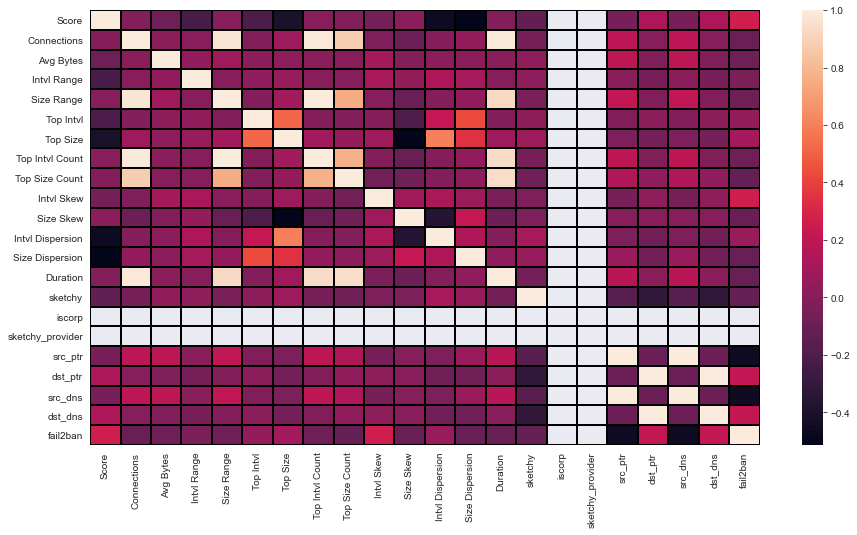

In [80]:
fig= plt.figure(figsize=(15,8))
sns.heatmap(df.corr(), linewidths=.1, linecolor='black')

### adding viz and stats

What are the most prevalent AS Numbers?

<AxesSubplot:>

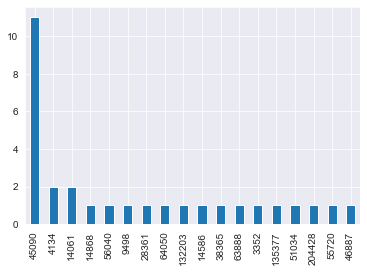

In [81]:
df['asn'][:30].value_counts().plot(kind='bar')

Where are they coming from?

<AxesSubplot:>

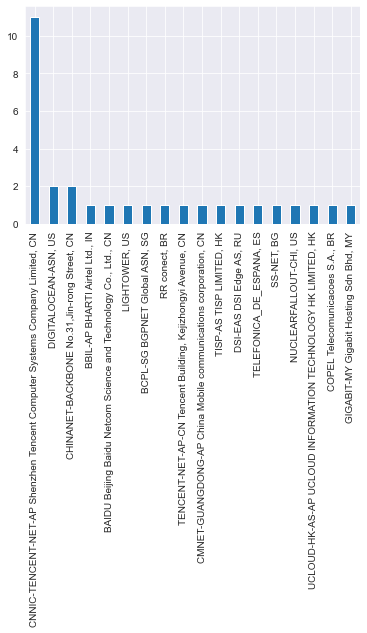

In [82]:
df['asn_desc'][:30].value_counts().plot(kind='bar')

What countries account for the most traffic?

<AxesSubplot:>

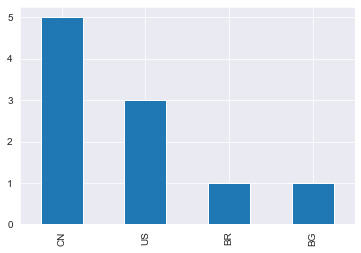

In [83]:
df['asn_country'][:10].value_counts().plot(kind='bar')

Is there a correlation between average bytes and number of connections?

<AxesSubplot:>

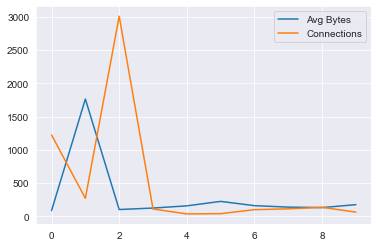

In [84]:
df[['Avg Bytes','Connections']][:10].plot()

**whats the relative occurrance of high beacon traffic?**

How about the occurrange of high beaconish traffic?

<AxesSubplot:>

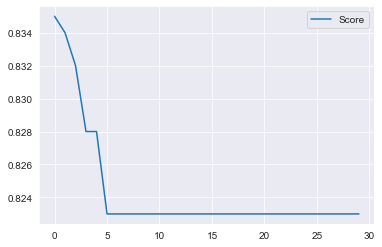

In [85]:
df[['Score']][:30].plot(y='Score')

<AxesSubplot:xlabel='Score', ylabel='Density'>

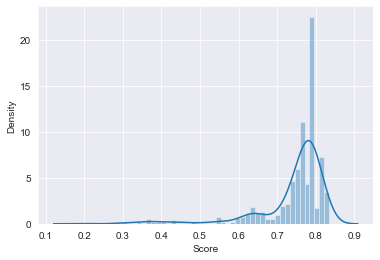

In [86]:
sns.distplot(df['Score'])

**how about long duration**

<AxesSubplot:xlabel='Duration', ylabel='Density'>

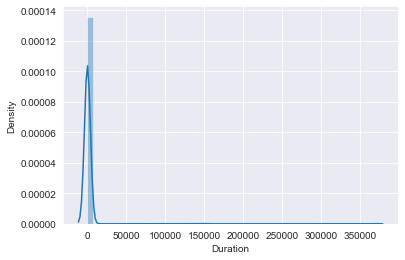

In [87]:
sns.distplot(df['Duration'])

#### how about services?


<AxesSubplot:>

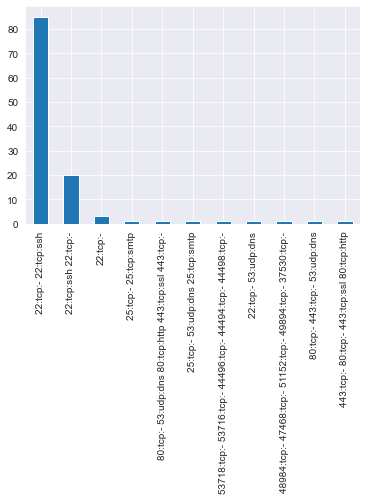

In [88]:
# The highest hits is fail2ban attempting to quash traffic, so we'll remove the ICMP entries
df[~df['Port:Protocol:Service'].str.contains('icmp')]['Port:Protocol:Service'].value_counts().plot(kind='bar')

### High Beaconish Originators

In [89]:
df[(df['Score'] >.80)][3:]['asn_desc']

3      CNNIC-TENCENT-NET-AP Shenzhen Tencent Computer...
4      TENCENT-NET-AP-CN Tencent Building, Kejizhongy...
5                                   DIGITALOCEAN-ASN, US
6      CNNIC-TENCENT-NET-AP Shenzhen Tencent Computer...
7            CHINANET-BACKBONE No.31,Jin-rong Street, CN
                             ...                        
110    CNNIC-TENCENT-NET-AP Shenzhen Tencent Computer...
111    TATACOMM-AS TATA Communications formerly VSNL ...
112    CNNIC-TENCENT-NET-AP Shenzhen Tencent Computer...
113    CNNIC-TENCENT-NET-AP Shenzhen Tencent Computer...
114                            TELEFONICA BRASIL S.A, BR
Name: asn_desc, Length: 112, dtype: object

In [90]:
df['asn_country'].value_counts()

CN    358
US    127
FR     28
HK     20
SG     17
RU     16
BR     16
IN     15
CA     13
KR     13
ID     12
VN     11
IT      9
MX      7
GB      6
TH      6
PH      5
JP      5
CO      5
AR      4
DE      4
IR      4
SC      4
PA      3
TW      3
PT      3
CL      3
HR      2
MY      2
ZA      2
AU      2
BG      2
EC      2
TR      1
NL      1
VE      1
ES      1
SE      1
PL      1
BE      1
LA      1
        1
GR      1
NG      1
CH      1
BY      1
MM      1
BO      1
GT      1
EG      1
KE      1
TN      1
IS      1
SV      1
PK      1
MN      1
PE      1
PS      1
Name: asn_country, dtype: int64

In [91]:
# highest traffic country entries
df[df['asn_country'] =='CN']

,Score,Source IP,Destination IP,Connections,Avg Bytes,Intvl Range,Size Range,Top Intvl,Top Size,Top Intvl Count,...,asn_desc,sketchy,iscorp,sketchy_provider,src_ptr,Destination Name,dst_ptr,src_dns,dst_dns,fail2ban
3,0.828,49.235.37.144,192.168.23.89,112,126,179,1853,44,60,26,...,CNNIC-TENCENT-NET-AP Shenzhen Tencent Computer...,True,False,False,False,192.168.23.89,False,False,False,False
4,0.828,192.168.23.89,119.28.83.164,38,159,241,2192,62,88,9,...,"TENCENT-NET-AP-CN Tencent Building, Kejizhongy...",True,False,False,False,119.28.83.164,False,False,False,True
6,0.823,192.168.23.89,49.233.77.12,102,162,268,2564,85,88,15,...,CNNIC-TENCENT-NET-AP Shenzhen Tencent Computer...,True,False,False,False,49.233.77.12,False,False,False,True
7,0.823,192.168.23.89,27.128.236.189,114,140,162,2036,80,88,19,...,"CHINANET-BACKBONE No.31,Jin-rong Street, CN",True,False,False,False,27.128.236.189,False,False,False,True
9,0.823,192.168.23.89,118.24.134.15,65,177,153,2152,136,88,11,...,CNNIC-TENCENT-NET-AP Shenzhen Tencent Computer...,True,False,False,False,118.24.134.15,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
747,0.342,192.168.23.89,218.92.0.175,28,676,555991,1780,111,264,1,...,"CHINANET-BACKBONE No.31,Jin-rong Street, CN",True,False,False,False,218.92.0.175,False,False,False,True
749,0.316,192.168.23.89,221.131.165.86,44,1558,125209,2108,1775,264,1,...,CMNET-JIANGSU-AP China Mobile communications c...,True,False,False,False,221.131.165.86,False,False,False,True
750,0.310,192.168.23.89,221.181.185.29,70,1710,65032,2052,1750,2220,2,...,CMNET-JIANGSU-AP China Mobile communications c...,True,False,False,False,221.181.185.29,False,False,False,True
751,0.301,192.168.23.89,182.61.52.98,41,521,1430,4728,176,88,4,...,BAIDU Beijing Baidu Netcom Science and Technol...,True,False,False,False,182.61.52.98,False,False,False,True


### build a view of connections where duration value is short and beaconish is high

In [92]:
# What are the relative duration statistics?
df['Duration'].describe()

count       754.000000
mean        838.921720
std       14412.220971
min          99.789500
25%         116.089750
50%         129.967000
75%         162.906000
max      367302.000000
Name: Duration, dtype: float64

In [93]:
# What is the relative score distribution?
df['Score'].describe()

count    754.000000
mean       0.743745
std        0.093160
min        0.195000
25%        0.739000
50%        0.771000
75%        0.789000
max        0.835000
Name: Score, dtype: float64

In [94]:
# looking at raw duration length values
df['Duration'].sort_values()

706        99.7895
720        99.7956
455       100.1650
697       100.2780
714       100.6400
          ...     
751      1430.5600
404      2029.6400
2        7123.6100
646    148167.0000
529    367302.0000
Name: Duration, Length: 754, dtype: float64

**Start drilling down**

Find the mean of all the Duration values. Use the Mean to determine how ordinary the duration of the traffic is

In [95]:
# 
df['Duration'].mean()

838.9217202917771

In [96]:
# Show only durations below the mean
df[df['Duration'] < df['Duration'].mean()]

,Score,Source IP,Destination IP,Connections,Avg Bytes,Intvl Range,Size Range,Top Intvl,Top Size,Top Intvl Count,...,asn_desc,sketchy,iscorp,sketchy_provider,src_ptr,Destination Name,dst_ptr,src_dns,dst_dns,fail2ban
0,0.835,65.254.18.118,192.168.23.89,1224,88,101090,7306,600,60,1052,...,"LIGHTOWER, US",False,False,False,True,192.168.23.89,False,True,False,False
1,0.834,104.153.105.82,192.168.23.89,272,1762,356385,147842,1,0,81,...,"NUCLEARFALLOUT-CHI, US",False,False,False,True,192.168.23.89,False,True,False,False
3,0.828,49.235.37.144,192.168.23.89,112,126,179,1853,44,60,26,...,CNNIC-TENCENT-NET-AP Shenzhen Tencent Computer...,True,False,False,False,192.168.23.89,False,False,False,False
4,0.828,192.168.23.89,119.28.83.164,38,159,241,2192,62,88,9,...,"TENCENT-NET-AP-CN Tencent Building, Kejizhongy...",True,False,False,False,119.28.83.164,False,False,False,True
5,0.823,192.168.23.89,157.230.210.84,42,226,220,1944,208,88,7,...,"DIGITALOCEAN-ASN, US",False,False,False,False,157.230.210.84,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
748,0.334,192.168.23.89,202.153.37.194,34,1452,801,4576,197,704,3,...,"EXCELL-AS Excellmedia, IN",True,False,False,False,202.153.37.194,False,False,False,True
749,0.316,192.168.23.89,221.131.165.86,44,1558,125209,2108,1775,264,1,...,CMNET-JIANGSU-AP China Mobile communications c...,True,False,False,False,221.131.165.86,False,False,False,True
750,0.310,192.168.23.89,221.181.185.29,70,1710,65032,2052,1750,2220,2,...,CMNET-JIANGSU-AP China Mobile communications c...,True,False,False,False,221.181.185.29,False,False,False,True
752,0.287,192.168.23.89,221.181.185.135,33,1619,153173,1956,1748,2220,1,...,CMNET-JIANGSU-AP China Mobile communications c...,True,False,False,False,221.181.185.135,False,False,False,True


**what are connections where duration is below a particular quantile?**

In [97]:
df[df['Duration'] < df['Duration'].quantile(.2)]

,Score,Source IP,Destination IP,Connections,Avg Bytes,Intvl Range,Size Range,Top Intvl,Top Size,Top Intvl Count,...,asn_desc,sketchy,iscorp,sketchy_provider,src_ptr,Destination Name,dst_ptr,src_dns,dst_dns,fail2ban
3,0.828,49.235.37.144,192.168.23.89,112,126,179,1853,44,60,26,...,CNNIC-TENCENT-NET-AP Shenzhen Tencent Computer...,True,False,False,False,192.168.23.89,False,False,False,False
22,0.823,192.168.23.89,121.4.115.189,92,147,101,1792,91,88,16,...,CNNIC-TENCENT-NET-AP Shenzhen Tencent Computer...,True,False,False,False,121.4.115.189,False,False,False,True
30,0.823,192.168.23.89,115.159.157.154,47,188,210,2072,96,88,7,...,CNNIC-TENCENT-NET-AP Shenzhen Tencent Computer...,True,False,False,False,115.159.157.154,False,False,False,True
38,0.817,192.168.23.89,150.158.165.134,40,225,555819,1840,232,88,7,...,CNNIC-TENCENT-NET-AP Shenzhen Tencent Computer...,True,False,False,False,150.158.165.134,False,False,False,True
47,0.817,45.119.126.59,192.168.23.89,62,268,261612,1801,163,60,8,...,"ANCHGLOBAL-AS-AP Anchnet Asia Limited, HK",True,False,False,False,192.168.23.89,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
739,0.380,195.54.160.250,192.168.23.89,68,998,91180,4020,4,40,12,...,"SELECTEL, RU",True,False,False,False,192.168.23.89,False,False,False,False
740,0.369,45.93.201.193,192.168.23.89,82,768,99183,4020,3,40,11,...,"SELECTEL-MSK, RU",True,False,False,False,192.168.23.89,False,False,False,False
743,0.368,120.92.79.133,192.168.23.89,102,246,705762,1801,7,60,45,...,BJKSCNET Beijing Kingsoft Cloud Internet Techn...,True,False,False,False,192.168.23.89,False,False,False,False
745,0.354,118.70.233.206,192.168.23.89,103,235,714,1801,7,60,46,...,FPT-AS-AP The Corporation for Financing & Prom...,True,False,False,False,192.168.23.89,False,False,False,False


**connections where duration value is short and beaconish is high**

- only get low duration connections which exhibit above %75 beaconism 

In this case, there a bunch of ICMP messages originating from my host heading to (mostly) China. If fail2ban wasn't running this might be cause for further investigation, but fail2ban sends ICMP type 3 packets to an originator when it gets jailed. We're catching this upstream in the fail2ban column. 

In [98]:
print(len(df[(df['Duration'] < df['Duration'].quantile(.2)) & (df['Score'] > .75)]))
df[(df['Duration'] < df['Duration'].quantile(.2)) & (df['Score'] > .75)][:3]

82


,Score,Source IP,Destination IP,Connections,Avg Bytes,Intvl Range,Size Range,Top Intvl,Top Size,Top Intvl Count,...,asn_desc,sketchy,iscorp,sketchy_provider,src_ptr,Destination Name,dst_ptr,src_dns,dst_dns,fail2ban
3,0.828,49.235.37.144,192.168.23.89,112,126,179,1853,44,60,26,...,CNNIC-TENCENT-NET-AP Shenzhen Tencent Computer...,True,False,False,False,192.168.23.89,False,False,False,False
22,0.823,192.168.23.89,121.4.115.189,92,147,101,1792,91,88,16,...,CNNIC-TENCENT-NET-AP Shenzhen Tencent Computer...,True,False,False,False,121.4.115.189,False,False,False,True
30,0.823,192.168.23.89,115.159.157.154,47,188,210,2072,96,88,7,...,CNNIC-TENCENT-NET-AP Shenzhen Tencent Computer...,True,False,False,False,115.159.157.154,False,False,False,True


**if anything is left that's not fail2ban there is something to dig further into**

In [99]:
# if anything is left that's not fail2ban there is something to dig further into
df[(df['Duration'] < df['Duration'].quantile(.2)) & (df['Score'] > .75)&(~df['fail2ban'])][:10]

,Score,Source IP,Destination IP,Connections,Avg Bytes,Intvl Range,Size Range,Top Intvl,Top Size,Top Intvl Count,...,asn_desc,sketchy,iscorp,sketchy_provider,src_ptr,Destination Name,dst_ptr,src_dns,dst_dns,fail2ban
3,0.828,49.235.37.144,192.168.23.89,112,126,179,1853,44,60,26,...,CNNIC-TENCENT-NET-AP Shenzhen Tencent Computer...,True,False,False,False,192.168.23.89,False,False,False,False
47,0.817,45.119.126.59,192.168.23.89,62,268,261612,1801,163,60,8,...,"ANCHGLOBAL-AS-AP Anchnet Asia Limited, HK",True,False,False,False,192.168.23.89,False,False,False,False
56,0.817,120.70.98.132,192.168.23.89,58,277,672,1713,167,60,6,...,"CHINANET-BACKBONE No.31,Jin-rong Street, CN",True,False,False,False,192.168.23.89,False,False,False,False
70,0.817,61.221.64.5,192.168.23.89,46,243,599,1801,150,60,6,...,"HINET Data Communication Business Group, TW",True,False,False,True,192.168.23.89,False,True,False,False
74,0.812,202.95.14.159,192.168.23.89,50,323,1025,1941,213,60,5,...,"BCPL-SG BGPNET Global ASN, SG",False,False,False,False,192.168.23.89,False,False,False,False
75,0.812,190.210.182.179,192.168.23.89,51,186,1160,1841,167,60,5,...,"NSS S.A., AR",False,False,False,True,192.168.23.89,False,True,False,False
124,0.793,106.124.131.214,192.168.23.89,156,139,200,1777,49,60,18,...,"CHINANET-BACKBONE No.31,Jin-rong Street, CN",True,False,False,False,192.168.23.89,False,False,False,False
131,0.793,157.131.240.195,192.168.23.89,63,268,855,1969,161,60,9,...,"AS-SONICTELECOM, US",False,False,False,True,192.168.23.89,False,True,False,False
149,0.793,49.232.39.21,192.168.23.89,119,154,287,1853,88,60,13,...,CNNIC-TENCENT-NET-AP Shenzhen Tencent Computer...,True,False,False,False,192.168.23.89,False,False,False,False
150,0.793,211.219.18.186,192.168.23.89,59,277,1517,1801,168,60,6,...,"KIXS-AS-KR Korea Telecom, KR",True,False,False,False,192.168.23.89,False,False,False,False


**is anything not originating from my ip?**

In [100]:
# is anything not originating from my ip?
df[(df['Duration'] < df['Duration'].quantile(.2)) & (df['Score'] > .75)]['Source IP'].unique()

array(['49.235.37.144', '192.168.23.89', '45.119.126.59', '120.70.98.132',
       '61.221.64.5', '202.95.14.159', '190.210.182.179',
       '106.124.131.214', '157.131.240.195', '49.232.39.21',
       '211.219.18.186', '123.206.90.149', '190.85.94.106',
       '49.233.77.12', '114.219.157.97', '210.178.94.227',
       '118.212.146.30', '106.75.61.147', '35.220.253.166',
       '119.45.177.219', '125.5.180.84', '134.175.111.215',
       '134.209.41.198', '189.110.163.26', '116.228.233.91',
       '190.171.133.10', '144.91.70.164', '101.89.213.84',
       '118.98.96.184', '64.64.227.224', '222.168.18.227', '103.10.87.54',
       '203.195.207.85', '101.36.127.150', '2.196.193.181',
       '123.127.244.100', '121.241.244.92', '182.254.149.130',
       '81.68.243.13', '106.124.142.64', '1.220.185.149', '123.30.149.34',
       '103.55.62.78', '118.24.121.227', '120.92.166.166',
       '121.4.138.185', '49.235.29.185', '140.249.222.242',
       '121.5.60.195', '96.69.13.140', '220.164.250.31'

**look at only non-fail2ban items where Duration is in the upper quantile, Score is greater than .75 and originates from my server**

In [101]:
# look at only non-fail2ban items where Duration is in the upper quantile, Score is greater than .75 and originates from my server
# nothing here - so it looks like beaconish activity here is fail2ban related (handled by )
df[(df['Duration'] < df['Duration'].quantile(.2)) & (df['Score'] > .75)& (~df['fail2ban']) &(df['Source IP'].str.contains('192.168.23.89'))]

,Score,Source IP,Destination IP,Connections,Avg Bytes,Intvl Range,Size Range,Top Intvl,Top Size,Top Intvl Count,...,asn_desc,sketchy,iscorp,sketchy_provider,src_ptr,Destination Name,dst_ptr,src_dns,dst_dns,fail2ban


In [102]:
df[(df['Duration'] < df['Duration'].quantile(.2)) & (df['Score'] > .75)&(df['Source IP'] != '192.168.23.89')]

,Score,Source IP,Destination IP,Connections,Avg Bytes,Intvl Range,Size Range,Top Intvl,Top Size,Top Intvl Count,...,asn_desc,sketchy,iscorp,sketchy_provider,src_ptr,Destination Name,dst_ptr,src_dns,dst_dns,fail2ban
3,0.828,49.235.37.144,192.168.23.89,112,126,179,1853,44,60,26,...,CNNIC-TENCENT-NET-AP Shenzhen Tencent Computer...,True,False,False,False,192.168.23.89,False,False,False,False
47,0.817,45.119.126.59,192.168.23.89,62,268,261612,1801,163,60,8,...,"ANCHGLOBAL-AS-AP Anchnet Asia Limited, HK",True,False,False,False,192.168.23.89,False,False,False,False
56,0.817,120.70.98.132,192.168.23.89,58,277,672,1713,167,60,6,...,"CHINANET-BACKBONE No.31,Jin-rong Street, CN",True,False,False,False,192.168.23.89,False,False,False,False
70,0.817,61.221.64.5,192.168.23.89,46,243,599,1801,150,60,6,...,"HINET Data Communication Business Group, TW",True,False,False,True,192.168.23.89,False,True,False,False
74,0.812,202.95.14.159,192.168.23.89,50,323,1025,1941,213,60,5,...,"BCPL-SG BGPNET Global ASN, SG",False,False,False,False,192.168.23.89,False,False,False,False
75,0.812,190.210.182.179,192.168.23.89,51,186,1160,1841,167,60,5,...,"NSS S.A., AR",False,False,False,True,192.168.23.89,False,True,False,False
124,0.793,106.124.131.214,192.168.23.89,156,139,200,1777,49,60,18,...,"CHINANET-BACKBONE No.31,Jin-rong Street, CN",True,False,False,False,192.168.23.89,False,False,False,False
131,0.793,157.131.240.195,192.168.23.89,63,268,855,1969,161,60,9,...,"AS-SONICTELECOM, US",False,False,False,True,192.168.23.89,False,True,False,False
149,0.793,49.232.39.21,192.168.23.89,119,154,287,1853,88,60,13,...,CNNIC-TENCENT-NET-AP Shenzhen Tencent Computer...,True,False,False,False,192.168.23.89,False,False,False,False
150,0.793,211.219.18.186,192.168.23.89,59,277,1517,1801,168,60,6,...,"KIXS-AS-KR Korea Telecom, KR",True,False,False,False,192.168.23.89,False,False,False,False


**a quick tool to see if an ipaddress is in the pandas datastore**

In [103]:
def showline(ipaddress):
    return df[df['Source IP'] == ipaddress]

In [104]:
showline('123.127.244.100')

,Score,Source IP,Destination IP,Connections,Avg Bytes,Intvl Range,Size Range,Top Intvl,Top Size,Top Intvl Count,...,asn_desc,sketchy,iscorp,sketchy_provider,src_ptr,Destination Name,dst_ptr,src_dns,dst_dns,fail2ban
368,0.773,123.127.244.100,192.168.23.89,62,263,1365,1817,162,60,6,...,CHINA169-BJ China Unicom Beijing Province Netw...,True,False,False,False,192.168.23.89,False,False,False,False


**where are ssh connections coming/going?**

In [105]:
# where are ssh connections coming/going?
# everything appears to be incoming, so we aren't launching any attacks
df[(df['Port:Protocol:Service'].str.contains('ssh')) & (df['Source IP'] != "10.4.86.55")]['ConnString'].unique()

array(['49.235.37.144->192.168.23.89', '42.192.234.75->192.168.23.89',
       '45.119.126.59->192.168.23.89', '120.70.98.132->192.168.23.89',
       '61.221.64.5->192.168.23.89', '202.95.14.159->192.168.23.89',
       '190.210.182.179->192.168.23.89', '106.124.131.214->192.168.23.89',
       '157.131.240.195->192.168.23.89', '49.232.39.21->192.168.23.89',
       '211.219.18.186->192.168.23.89', '123.206.90.149->192.168.23.89',
       '190.85.94.106->192.168.23.89', '49.233.77.12->192.168.23.89',
       '114.219.157.97->192.168.23.89', '210.178.94.227->192.168.23.89',
       '118.212.146.30->192.168.23.89', '106.75.61.147->192.168.23.89',
       '129.211.119.202->192.168.23.89', '35.220.253.166->192.168.23.89',
       '119.45.177.219->192.168.23.89', '125.5.180.84->192.168.23.89',
       '134.175.111.215->192.168.23.89', '134.209.41.198->192.168.23.89',
       '189.110.163.26->192.168.23.89', '116.228.233.91->192.168.23.89',
       '190.171.133.10->192.168.23.89', '144.91.70.164->192.16

**show all unique source names with scores above 80%**

In [106]:
# show all unique source names with scores above 80%
df[df['Score']> .8]['Source Name'].unique()

array(['smtp.jobdivabk.com',
       'v-104-153-105-82.unman-vds.premium-chicago.nfoservers.com',
       '192.168.23.89', '49.235.37.144', '42.192.234.75', '45.119.126.59',
       '120.70.98.132', '61-221-64-5.hinet-ip.hinet.net', '202.95.14.159',
       'customer-static-210-182-179.iplannetworks.net'], dtype=object)

### Blacklists

Adding a blacklist heuristic. Most of rita-bl seems borked right now (stale data, backends offline, etc). In the meantime, lets get visibility using the spamhaus data.

In [107]:
# importing a custom, line-delimited list
blacklistraw = open('20210827154850_blacklisted_ips.txt','r').readlines()
blacklist = [x.strip('\n') for x in blacklistraw]

In [108]:
def blacklist_test(ip):
    badreturns = []
    hits = []
    if ip in blacklist:
        hits.append(ip)
#     else:
#         badreturns.append(ip)
    if len(hits) > 0:
        return hits

In [109]:
def in_blacklist(ip):
    if ip not in blacklist:
        return False
    return True

In [110]:
# add feature
df['blacklisted'] = df['Destination IP'].apply(in_blacklist)

In [111]:
# are there any hits?
df[df['blacklisted']]

,Score,Source IP,Destination IP,Connections,Avg Bytes,Intvl Range,Size Range,Top Intvl,Top Size,Top Intvl Count,...,sketchy,iscorp,sketchy_provider,src_ptr,Destination Name,dst_ptr,src_dns,dst_dns,fail2ban,blacklisted


### Heuristics 
#### show the tally points

Here we want to score based on the conditions. Some things are bad if they're True (sketchy TLD like Russia or China) some are bad if they're False (no reverse_ptr). Scoring needs a scale: some things are inherently worse (domain is the source of an attack in the wild) and some are not (reverse DNS).

reasons to believe the traffic is not good (this could use expansion)
sketchy - if True (the connection is from a poorly managed country tld) add 3
fail2ban - if True (domain is spawning attacks in the wild) add 3
sketchy_provider - if True then bad - add 3

formal laziness: 
src_ptr - if they are the source and his is false, then bad 2
dst_ptr - if they are the dst and it is false, then bad 2
src_dns - if they are the source and his is false, then bad 2
dst_dns - if they are the dst and it is false, then bad 2

corporate canaries:
iscorp - corporate canaries (apple, google, microsoft, etc). If true, then bad (though probably harmless). 1  



so what I need is:
- a feature that lets me know if src/dst is important for ptr and dns
- a function that returns the value if the feature is present for each item and then tallies a score to be added as a feature.

In [112]:
# adding a "score" feature first - Beaconish Score (how likely is this a problematic beacon?)
df['bscore'] = 0

In [113]:
# we're tallying on these columns
df[['sketchy','src_ptr','dst_ptr','iscorp','sketchy_provider','src_dns','dst_dns','fail2ban', 'blacklisted']][:5]

,sketchy,src_ptr,dst_ptr,iscorp,sketchy_provider,src_dns,dst_dns,fail2ban,blacklisted
0,False,True,False,False,False,True,False,False,False
1,False,True,False,False,False,True,False,False,False
2,False,False,False,False,False,False,False,True,False
3,True,False,False,False,False,False,False,False,False
4,True,False,False,False,False,False,False,True,False


In [114]:
def tally_total(item):
    """
    tally up scores per row. 
    where are we **sending** data (beacons)?
    need the columns
    df[['Score','asn',sketchy','src_ptr','dst_ptr','iscorp','sketchy_provider','src_dns','dst_dns','fail2ban','blacklisted']]

    must call apply with axis=1 e.g.
    df[['Score','asn','sketchy','src_ptr','dst_ptr','iscorp','sketchy_provider','src_dns','dst_dns','fail2ban','blacklisted']].apply(test_return,axis=1)
    """

    total=item['bscore']
    
    # presuming our internal network is in RFC1918. Open Internet Addresses should have reverse pointers and DNS, even if we don't internally
    if item['asn'] == 'rfc1918':
        if not item['src_ptr']:
            total +=2
        elif not item['src_dns']:
            total +=2
    elif item['asn'] != 'rfc1918':
        if not item['dst_ptr']:
            total +=2
        elif not item['dst_dns']:
            total +=2
    # fail2ban violations are from 
    if item['fail2ban'] :
        total +=3
    # is the connection to a sketchy country?
    elif item['sketchy']:
        total+=3
    # how about to a sketchy provider?
    elif item['sketchy_provider']:
        total +=3
    # is the IP in the spamhaus blacklist?
    elif item['blacklisted']:
        total +=3
    # corporate spyware is the lowest priority. This scoring should make it easier to build filters, also.
    elif item['iscorp']:
        total +=1
    return total
        
        

In [115]:
# using tally_total
df[['bscore','asn','sketchy','src_ptr','dst_ptr','iscorp','sketchy_provider','src_dns','dst_dns','fail2ban','blacklisted']][:10].apply(tally_total,axis=1)

0    2
1    2
2    5
3    5
4    5
5    5
6    5
7    5
8    3
9    5
dtype: int64

In [116]:
# full scoring
# using tally_total
df['bscore'] = df[['bscore','asn','sketchy','src_ptr','dst_ptr','iscorp','sketchy_provider','src_dns','dst_dns','fail2ban','blacklisted']].apply(tally_total,axis=1)

In [117]:
df[:5].sort_values(by='bscore', ascending=False)

,Score,Source IP,Destination IP,Connections,Avg Bytes,Intvl Range,Size Range,Top Intvl,Top Size,Top Intvl Count,...,iscorp,sketchy_provider,src_ptr,Destination Name,dst_ptr,src_dns,dst_dns,fail2ban,blacklisted,bscore
2,0.832,192.168.23.89,212.70.149.71,3005,104,7209,45408,110,88,930,...,False,False,False,212.70.149.71,False,False,False,True,False,5
3,0.828,49.235.37.144,192.168.23.89,112,126,179,1853,44,60,26,...,False,False,False,192.168.23.89,False,False,False,False,False,5
4,0.828,192.168.23.89,119.28.83.164,38,159,241,2192,62,88,9,...,False,False,False,119.28.83.164,False,False,False,True,False,5
0,0.835,65.254.18.118,192.168.23.89,1224,88,101090,7306,600,60,1052,...,False,False,True,192.168.23.89,False,True,False,False,False,2
1,0.834,104.153.105.82,192.168.23.89,272,1762,356385,147842,1,0,81,...,False,False,True,192.168.23.89,False,True,False,False,False,2


#### Now create a total score

Now to make the single value that represents RITA's statistical analysis score ('Score') and our heuristical score ('bscore'). For the moment it seems that Score * bscore is useful because Score is a Percentage which should scale the raw heuristical tally nicely.

In [118]:
def total_score(row):
    """
    multiply RITA score and bscore
    Usage:
    df[['Score','bscore']].apply(total_score,axis=1)
    """
    return row['Score'] * row['bscore']

In [119]:
df[['Score','bscore']][:10].apply(total_score,axis=1)

0    1.670
1    1.668
2    4.160
3    4.140
4    4.140
5    4.115
6    4.115
7    4.115
8    2.469
9    4.115
dtype: float64

##### create the new feature

In [120]:
df['total_score'] = df[['Score','bscore']].apply(total_score,axis=1)

##### Sort the list by total score 

Non-corp connections should bubble up and we should only be grading on bad actors and malware.

In [121]:
df[:10].sort_values(by='total_score', ascending=False)

,Score,Source IP,Destination IP,Connections,Avg Bytes,Intvl Range,Size Range,Top Intvl,Top Size,Top Intvl Count,...,sketchy_provider,src_ptr,Destination Name,dst_ptr,src_dns,dst_dns,fail2ban,blacklisted,bscore,total_score
2,0.832,192.168.23.89,212.70.149.71,3005,104,7209,45408,110,88,930,...,False,False,212.70.149.71,False,False,False,True,False,5,4.160
3,0.828,49.235.37.144,192.168.23.89,112,126,179,1853,44,60,26,...,False,False,192.168.23.89,False,False,False,False,False,5,4.140
4,0.828,192.168.23.89,119.28.83.164,38,159,241,2192,62,88,9,...,False,False,119.28.83.164,False,False,False,True,False,5,4.140
5,0.823,192.168.23.89,157.230.210.84,42,226,220,1944,208,88,7,...,False,False,157.230.210.84,False,False,False,True,False,5,4.115
6,0.823,192.168.23.89,49.233.77.12,102,162,268,2564,85,88,15,...,False,False,49.233.77.12,False,False,False,True,False,5,4.115
7,0.823,192.168.23.89,27.128.236.189,114,140,162,2036,80,88,19,...,False,False,27.128.236.189,False,False,False,True,False,5,4.115
9,0.823,192.168.23.89,118.24.134.15,65,177,153,2152,136,88,11,...,False,False,118.24.134.15,False,False,False,True,False,5,4.115
8,0.823,192.168.23.89,179.97.86.254,137,133,146,2120,68,88,23,...,False,False,254-86-97-179.rrconect.com.br,True,False,True,True,False,3,2.469
0,0.835,65.254.18.118,192.168.23.89,1224,88,101090,7306,600,60,1052,...,False,True,192.168.23.89,False,True,False,False,False,2,1.670
1,0.834,104.153.105.82,192.168.23.89,272,1762,356385,147842,1,0,81,...,False,True,192.168.23.89,False,True,False,False,False,2,1.668


<AxesSubplot:xlabel='bscore', ylabel='Density'>

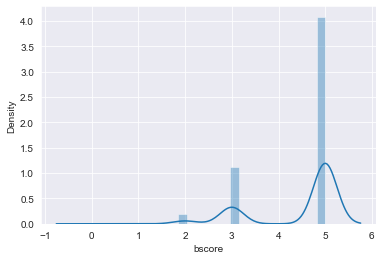

In [124]:
sns.distplot(df['bscore'])

<AxesSubplot:xlabel='total_score', ylabel='Density'>

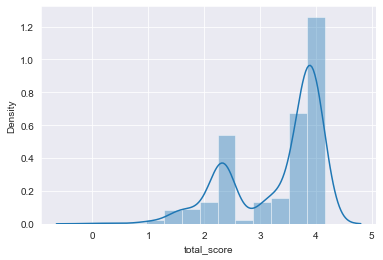

In [125]:
sns.distplot(df['total_score'])

## Final

And that's the basic process. I want to be able to scan through connections at least daily, then export the outputs to a datastore or to reporting for the Sec Team to follow up on. 

TODOs include: 
- building this into a running script
- summarize this as a report (that could be used to kick off tickets)
- auto export the ranking to a datastore that other apps could use
- make the heuristics modular such that we can import blacklists, etc



In [122]:
df.columns

Index(['Score', 'Source IP', 'Destination IP', 'Connections', 'Avg Bytes',
       'Intvl Range', 'Size Range', 'Top Intvl', 'Top Size', 'Top Intvl Count',
       'Top Size Count', 'Intvl Skew', 'Size Skew', 'Intvl Dispersion',
       'Size Dispersion', 'ConnString', 'Port:Protocol:Service', 'Duration',
       'Source Name', 'asn', 'asn_cidr', 'asn_country', 'asn_desc', 'sketchy',
       'iscorp', 'sketchy_provider', 'src_ptr', 'Destination Name', 'dst_ptr',
       'src_dns', 'dst_dns', 'fail2ban', 'blacklisted', 'bscore',
       'total_score'],
      dtype='object')

## Summarize reporting

In [123]:
df[['Score','bscore', 'total_score','Source Name', 'Destination Name', 'Connections', 'Avg Bytes','asn_desc','asn_country']].sort_values(by='total_score', ascending=False)

,Score,bscore,total_score,Source Name,Destination Name,Connections,Avg Bytes,asn_desc,asn_country
2,0.832,5,4.160,192.168.23.89,212.70.149.71,3005,104,"SS-NET, BG",BG
3,0.828,5,4.140,49.235.37.144,192.168.23.89,112,126,CNNIC-TENCENT-NET-AP Shenzhen Tencent Computer...,CN
4,0.828,5,4.140,192.168.23.89,119.28.83.164,38,159,"TENCENT-NET-AP-CN Tencent Building, Kejizhongy...",CN
24,0.823,5,4.115,192.168.23.89,49.235.41.58,48,149,CNNIC-TENCENT-NET-AP Shenzhen Tencent Computer...,CN
16,0.823,5,4.115,192.168.23.89,183.232.250.154,46,230,CMNET-GUANGDONG-AP China Mobile communications...,CN
...,...,...,...,...,...,...,...,...,...
722,0.519,2,1.038,ns501934.ip-192-99-6.net,192.168.23.89,138,535,"OVH, FR",CA
723,0.507,2,1.014,reverse.rezaxess.fr,192.168.23.89,40,388,"REZOCEAN-AS, FR",FR
733,0.425,2,0.850,141.98.80.85,192.168.23.89,24,411,"NFORCE, NL",PA
753,0.195,2,0.390,205.185.125.54,192.168.23.89,492,862,"PONYNET, US",US
